Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

# References

* [Laurent Gautier](https://github.com/lgautier/pragmatic-polyglot-data-analysis)
* [PySpark Internals](https://cwiki.apache.org/confluence/display/SPARK/PySpark+Internals)
* [Apache Spark website](http://spark.apache.org)
* [Step by Step of installing Apache Spark on Apache Hadoop](https://chongyaorobin.wordpress.com/2015/07/01/step-by-step-of-installing-apache-spark-on-apache-hadoop/)

# Installation
```sh
 pip3 install findspark
 brew install scala
 brew install apache-spark
 pip3 install pyspark
```

*Note: PySpark requires a little additional setup. Usually, the following environment variables need to be set (using `/usr/libexec/java_home` on OS X or similar on Linux)*:

```bash
export JAVA_HOME="$(/usr/libexec/java_home)"
```

*Also, VPNs can interfere with PySpark, so you may need to disable yours if you are running PySpark locally.*

Check version of spark with `brew info apache-spark` and set the variable
```bash
export SPARK_HOME="/usr/local/Cellar/apache-spark/2.2.0/libexec/"
export HADOOP_HOME="/usr/local/opt/hadoop/libexec/"
export HADOOP_CONF_DIR=${HADOOP_HOME}/etc/hadoop
```

![PySpark Internals](http://i.imgur.com/YlI8AqEl.png)

Apache Spark is a fast and general-purpose cluster computing system. It provides high-level APIs in Java, Scala, Python and R, and an optimized engine that supports general execution graphs. It also supports a rich set of higher-level tools including Spark SQL for SQL and structured data processing, MLlib for machine learning, GraphX for graph processing, and Spark Streaming.

Apache Spark provides APIs in non-JVM languages such as Python. Many data scientists use Python because it has a rich variety of numerical libraries with a statistical, machine-learning, or optimization focus.
[Cloudera website](https://www.cloudera.com/documentation/enterprise/5-5-x/topics/spark_ipython.html)

In [23]:
import findspark
findspark.init()

import pyspark

conf = pyspark.conf.SparkConf()
(conf.setMaster('local[2]')
 .setAppName('ipython-notebook')
 .set("spark.executor.memory", "2g"))

sc = pyspark.SparkContext(conf=conf)


In [24]:
print(sc) # it is like a Pool Processor executor

<SparkContext master=local[2] appName=ipython-notebook>


We have a spark context sc to use with a tiny local spark cluster with 2 nodes (will work just fine on a multicore machine).

# Parallel Collections

Systems like Spark and Dask include "big data" collections with a small set of high-level primitives like `map`, `filter`, `groupby`, and `join`.  With these common patterns we can often handle computations that are more complex than map, but are still structured.




In [25]:
rdd = sc.parallelize(range(5))  # create collection
rdd

PythonRDD[1] at RDD at PythonRDD.scala:48

From Python list we go to spark objects and back to python list.

In [3]:
rdd.collect()  # Gather results back to local process

[0, 1, 2, 3, 4]

### map

In [4]:
rdd.map(lambda x: x ** 2) # Square each element

PythonRDD[2] at RDD at PythonRDD.scala:48

In [5]:
rdd.map(lambda x: x ** 2).collect() # Square each element and collect results

[0, 1, 4, 9, 16]

In [6]:
rdd.filter(lambda x: x % 2 == 0).collect() # Select only the even elements‹

[0, 2, 4]

In [7]:
# Cartesian product of each pair of elements in two sequences 
# (or the same sequence in this case)
rdd.cartesian(rdd).collect()[:8]

[(0, 0), (0, 1), (1, 0), (1, 1), (0, 2), (0, 3), (0, 4), (1, 2)]

In [8]:
# Chain operations to construct more complex computations

(rdd.map(lambda x: x ** 2)
    .cartesian(rdd)
    .filter(lambda tup: tup[0] % 2 == 0)
    .collect())

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (4, 0),
 (4, 1),
 (16, 0),
 (16, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (16, 2),
 (16, 3),
 (16, 4)]

# Prepare data 

This python script generates some fake stock data by adding a bunch of points between real stock data points. We just need to get some data to work with, you don't need to understand these following lines. We get a list of json files containing dataframes. We will convert these files into hdf5 format and use them to extract some information.

In [2]:
# Parallel Data Analysis in Python 
# SciPy 2017 Tutorial 
# Matthew Rocklin, Ben Zaitlen & Aron Ahmadia
# https://github.com/pydata/parallel-tutorial
import os
from glob import glob
import pandas as pd
try:
    import ujson as json
except ImportError:
    import json

import dask
import dask.dataframe as dd
import dask.multiprocessing
import os
import sys

WINDOWS = sys.platform.startswith('win')

if WINDOWS:
    dask.set_options(get=dask.threaded.get)
else:
    dask.set_options(get=dask.multiprocessing.get)

here = os.getcwd()
os.makedirs(os.path.join(here, 'data', 'minute'), exist_ok=True)

stocks = ['afl', 'aig', 'al', 'amgn', 'avy', 'b', 'bwa', 'ge',
          'hal', 'hp', 'hpq', 'ibm', 'jbl', 'jpm', 'luv', 'met', 'pcg',
          'tgt', 'usb', 'xom']

def write_stock(symbol):
    dirname = os.path.join(here, 'data', 'minute', symbol)
    if not os.path.exists(dirname):
        os.mkdir(dirname)
        df = dd.demo.daily_stock(symbol, '2010', '2015', freq='120s',
                                 data_source='google')
        names = [str(ts.date()) for ts in df.divisions]
        df.to_csv(os.path.join(here, 'data', 'minute', symbol, '*.csv'),
                  name_function=names.__getitem__)
        print("Finished CSV: %s" % symbol)

for symbol in stocks:
    write_stock(symbol)

def convert_to_json(d):
    filenames = sorted(glob(os.path.join(d, '*')))[-365:]
    outfn = d.replace('minute', 'json') + '.json'
    if os.path.exists(outfn):
        return
    with open(outfn, 'w') as f:
        for fn in filenames:
            df = pd.read_csv(fn)
            for rec in df.to_dict(orient='records'):
                json.dump(rec, f)
                f.write('\n')
    print("Finished JSON: %s" % d.split(os.path.sep)[-1])

js = os.path.join(here, 'data', 'json')
if not os.path.exists(js):
    os.mkdir(js)

directories = sorted(glob(os.path.join(here, 'data', 'minute', '*')))
values = [dask.delayed(convert_to_json)(d) for d in directories]
dask.compute(values);

In [3]:
stocks

['afl',
 'aig',
 'al',
 'amgn',
 'avy',
 'b',
 'bwa',
 'ge',
 'hal',
 'hp',
 'hpq',
 'ibm',
 'jbl',
 'jpm',
 'luv',
 'met',
 'pcg',
 'tgt',
 'usb',
 'xom']

In [4]:
filenames = sorted(glob(os.path.join('.', 'data', 'json', '*.json')))  # ../data/json/*.json
filenames[:5]

['./data/json/aet.json',
 './data/json/afl.json',
 './data/json/aig.json',
 './data/json/al.json',
 './data/json/amgn.json']

In [5]:
%%time

### Sequential code

for fn in filenames:
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')

CPU times: user 5.33 s, sys: 617 ms, total: 5.95 s
Wall time: 6.03 s


```bash
pip3 install snakeviz tables
```

In [43]:
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


### Convert JSON data to HDF5 in parallel

In [30]:
%%snakeviz

for fn in filenames:
    print(fn)
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')

./data/json/aet.json
./data/json/afl.json
./data/json/aig.json
./data/json/al.json
./data/json/amgn.json
./data/json/avy.json
./data/json/b.json
./data/json/bwa.json
./data/json/ge.json
./data/json/hal.json
./data/json/hp.json
./data/json/hpq.json
./data/json/ibm.json
./data/json/jbl.json
./data/json/jpm.json
./data/json/luv.json
./data/json/met.json
./data/json/pcg.json
./data/json/tgt.json
./data/json/usb.json
./data/json/xom.json
 
*** Profile stats marshalled to file '/var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmphbx8ox6x'. 


In [5]:
from glob import glob
import os
import pandas as pd

filenames = sorted(glob(os.path.join('.','data', 'json', '*.h5')))  # ./data/json/*.json
filenames[:5]

['./data/json/afl.h5',
 './data/json/aig.h5',
 './data/json/al.h5',
 './data/json/amgn.h5',
 './data/json/avy.h5']

Application
Given our HDF5 files from the last section we want to find the two datasets with the greatest pair-wise correlation. This forces us to consider all  $n \times (n−1)$
  possibilities.


## Sequential code

### Load data from disk


In [8]:
series = {} 
for fn in filenames:  
    series[fn] = pd.read_hdf(fn)['close']

In [10]:
%%time

results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print("%s matches with %s with correlation %f" % (a, b, corr))

./data/json/luv.h5 matches with ./data/json/hpq.h5 with correlation 0.934552
CPU times: user 503 ms, sys: 4.48 ms, total: 508 ms
Wall time: 507 ms


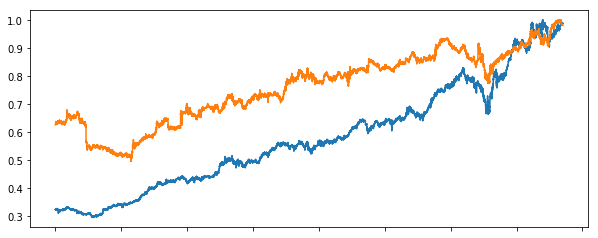

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series[a] / series[a].max())
plt.plot(series[b] / series[b].max())
plt.xticks(visible=False);

### Solve same problem with map.

In [14]:
%%time

series = []
for fn in filenames:   # Simple map over filenames
    series.append(pd.read_hdf(fn)['close'])

results = []

for a in series:    # Doubly nested loop over the same collection
    for b in series:  
        if not (a == b).all():     # Filter out comparisons of the same series 
            results.append(a.corr(b))  # Apply function

result = max(results)

CPU times: user 1.27 s, sys: 114 ms, total: 1.38 s
Wall time: 1.38 s


In [20]:
import numpy as np
np.array(results).argmax()

276

### Parallel code

In [13]:
rdd = sc.parallelize(filenames)
series = rdd.map(lambda fn: pd.read_hdf(fn)['close'])

corr = (series.cartesian(series)  # handles nested for loop
              .filter(lambda ab: not (ab[0] == ab[1]).all())
              .map(lambda ab: ab[0].corr(ab[1]))
              .max())

result = corr



In [14]:
result

0.9345517675657099

# Dask bag

In [16]:
import dask.bag as db

b = db.from_sequence(filenames)
series = b.map(lambda fn: pd.read_hdf(fn)['close'])

corr = (series.product(series) # handles nested for loop
              .filter(lambda ab: not (ab[0] == ab[1]).all())
              .map(lambda ab: ab[0].corr(ab[1]))
              .max())

result = corr.compute() # Effective computation of the lazy object


In [17]:
result

0.9345517675657099

## Use spark with mrjob

In [1]:
%%file mr_spark_word_count.py
import re
from operator import add

from mrjob.job import MRJob



WORD_RE = re.compile(r"[\w']+")

class MRSparkWordcount(MRJob):

    def spark(self, input_path, output_path):
        # Spark may not be available where script is launched
        
        from pyspark import SparkContext
        import findspark
        findspark.init()

        sc = SparkContext(appName='mrjob Spark wordcount script')

        lines = sc.textFile(input_path)

        counts = (
            lines.flatMap(lambda line: WORD_RE.findall(line))
            .map(lambda word: (word, 1))
            .reduceByKey(add))

        counts.saveAsTextFile(output_path)

        sc.stop()

if __name__ == '__main__':
    MRSparkWordcount.run()


Overwriting mr_spark_word_count.py


In [3]:
!env HADOOP_CONF_DIR=/usr/local/opt/hadoop/libexec/etc/hadoop \
     python3 mr_spark_word_count.py -r hadoop hadoop/sample.txt > output


No configs found; falling back on auto-configuration
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/local/bin/hadoop
Using Hadoop version 2.8.1
Looking for spark-submit binary in $PATH...
Found spark-submit binary: /usr/local/bin/spark-submit
Creating temp directory /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/mr_spark_word_count.navaro.20170905.100301.897215
Copying local files to hdfs:///user/navaro/tmp/mrjob/mr_spark_word_count.navaro.20170905.100301.897215/files/...
Running step 1 of 1...
  Your hostname, m-navaro resolves to a loopback address: 127.0.0.1; using 129.20.39.133 instead (on interface en0)
  Set SPARK_LOCAL_IP if you need to bind to another address
  Running Spark version 2.2.0
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  Submitted application: mrjob Spark wordcount script
  Changing view acls to: navaro
  Changing modify acls to: navaro
  Changing view acls groups to: 
  Changing modify 

  Initialized BlockManager: BlockManagerId(driver, 129.20.39.133, 58764, None)
  Started o.s.j.s.ServletContextHandler@295909c5{/metrics/json,null,AVAILABLE,@Spark}
  Registered executor NettyRpcEndpointRef(spark-client://Executor) (129.20.39.133:58768) with ID 1
  Registering block manager localhost:58769 with 366.3 MB RAM, BlockManagerId(1, localhost, 58769, None)
  Registered executor NettyRpcEndpointRef(spark-client://Executor) (129.20.39.133:58771) with ID 2
  Registering block manager localhost:58772 with 366.3 MB RAM, BlockManagerId(2, localhost, 58772, None)
  SchedulerBackend is ready for scheduling beginning after reached minRegisteredResourcesRatio: 0.8
  Block broadcast_0 stored as values in memory (estimated size 282.9 KB, free 366.0 MB)
  Block broadcast_0_piece0 stored as bytes in memory (estimated size 23.0 KB, free 366.0 MB)
  Added broadcast_0_piece0 in memory on 129.20.39.133:58764 (size: 23.0 KB, free: 366.3 MB)
  Created broadcast 0 from textFile at NativeMethodAcc